### Toulouse/Squidguard Model


In [1]:
from __future__ import print_function

import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

# https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
np.random.seed(1)
tf.random.set_seed(2)

NGRAMS = 2
FEATURE_LEN = 128

# Blacklists
df = pd.read_csv('../train-test/data/blacklists.csv.bz2')
df


,domain,blacklists_cat
0,59.52.114.68,phishing
1,eroticalee1.blogspot.ru,adult
2,jstanothergrly.blogspot.com.br,adult
3,youmightbest.tk,redirector|strict_redirector|strong_redirector
4,jstanothergrly.blogspot.com.by,adult
...,...,...
2140116,aqnjmquscyduyhw.blogspot.com.ng,adult
2140117,sexyhotmalemodels.blogspot.ug,adult
2140118,sex-in-sydney.blogspot.com.cy,adult
2140119,ipornx.blogspot.pe,adult


In [2]:
df['cat_count'] = df.blacklists_cat.apply(lambda c: len(c.split('|')))
sdf = df[df.cat_count == 1]
sdf

,domain,blacklists_cat,cat_count
0,59.52.114.68,phishing,1
1,eroticalee1.blogspot.ru,adult,1
2,jstanothergrly.blogspot.com.br,adult,1
4,jstanothergrly.blogspot.com.by,adult,1
5,edwardmax1.blogspot.com.au,adult,1
...,...,...,...
2140116,aqnjmquscyduyhw.blogspot.com.ng,adult,1
2140117,sexyhotmalemodels.blogspot.ug,adult,1
2140118,sex-in-sydney.blogspot.com.cy,adult,1
2140119,ipornx.blogspot.pe,adult,1


In [3]:
dom_group = sdf.groupby('blacklists_cat').agg({'domain': 'count'})
dom_group

,domain
blacklists_cat,
adult,1870741
agressif,304
arjel,11
associations_religieuses,1
astrology,27
audio-video,2977
bank,1689
bitcoin,251
blog,1425


### Take out categories that have less than 1000 domains.

In [4]:
filter_cat = list(dom_group[dom_group.domain > 1000].index)
#filter_cat = list(dom_group[dom_group.domain > 100].index)

### Take out categories that have recall < 0.3 (based on previous iterations of the model)

In [5]:
excat = ['audio-video', 'blog', 'dating', 'liste_bu', 'sports', 'publicite']

In [6]:
filter_cat = [x for x in filter_cat if x not in excat]
filter_cat

['adult',
 'bank',
 'gambling',
 'games',
 'malware',
 'phishing',
 'press',
 'shopping']

In [7]:
sdf.loc[sdf.blacklists_cat.isin(filter_cat) == False, 'blacklists_cat'] = 'others'

/opt/venv37/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [8]:
sdf.groupby('blacklists_cat').agg({'domain': 'count'})

,domain
blacklists_cat,
adult,1870741
bank,1689
gambling,1012
games,9357
malware,4463
others,21441
phishing,62712
press,4410
shopping,36331


## Preprocessing the input data

In [9]:
# build n-gram list
#vect = CountVectorizer(analyzer='char', max_df=0.3, min_df=3, ngram_range=(NGRAMS, NGRAMS), lowercase=False) 
vect = CountVectorizer(analyzer='char', ngram_range=(NGRAMS, NGRAMS), lowercase=False) 
a = vect.fit_transform(sdf.domain)
vocab = vect.vocabulary_

# sort n-gram by freq (highest -> lowest)
words = []
for b in vocab:
    c = vocab[b]
    #print(b, c, a[:, c].sum())
    words.append((a[:, c].sum(), b))
    #break
words = sorted(words, reverse=True)
words_list = [w[1] for w in words]
num_words = len(words_list)
print("num_words = %d" % num_words)


def find_ngrams(text, n):
    a = zip(*[text[i:] for i in range(n)])
    wi = []
    for i in a:
        w = ''.join(i)
        try:
            idx = words_list.index(w)
        except:
            idx = 0
        wi.append(idx)
    return wi

# build X from index of n-gram sequence
X = np.array(sdf.domain.apply(lambda c: find_ngrams(c, NGRAMS)))

# check max/avg feature
X_len = []
for x in X:
    X_len.append(len(x))

max_feature_len = max(X_len)
avg_feature_len = int(np.mean(X_len))

num_words = 1498


In [10]:
print("Max feature len = %d, Avg. feature len = %d" % (max_feature_len, avg_feature_len))
class_labels = sdf.blacklists_cat.astype('category').cat.categories
y = np.array(sdf.blacklists_cat.astype('category').cat.codes)

# Split train and test dataset
X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)
#X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# backup
y_train_lab = y_train
y_test_lab = y_test

Max feature len = 137, Avg. feature len = 23


In [11]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 374149,
 1: 338,
 2: 202,
 3: 1871,
 4: 893,
 5: 4288,
 6: 12543,
 7: 882,
 8: 7266}

In [12]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 1496592,
 1: 1351,
 2: 810,
 3: 7486,
 4: 3570,
 5: 17153,
 6: 50169,
 7: 3528,
 8: 29065}

## Train a LSTM model

In [13]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Activation
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import load_model

max_features = num_words # 20000
feature_len = FEATURE_LEN # avg_feature_len # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=feature_len)
X_test = sequence.pad_sequences(X_test, maxlen=feature_len)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

n_classes = np.max(y_train) + 1
print(n_classes, 'classes')

print('Convert class vector to binary class matrix '
      '(for use with categorical_crossentropy)')
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

Using TensorFlow backend.


1609724 train sequences
402432 test sequences
Pad sequences (samples x time)
X_train shape: (1609724, 128)
X_test shape: (402432, 128)
9 classes
Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (1609724, 9)
y_test shape: (402432, 9)


In [14]:
import pickle

# Load from file
with open('models/toulouse_cat_2017_rf.pickle', 'rb') as file:
    rf_model = pickle.load(file)

In [15]:
%%time
# Actual class predictions
rf_y_pred = rf_model.predict(X_test)
# Probabilities for each class
rf_y_score = rf_model.predict_proba(X_test)

CPU times: user 28.7 s, sys: 1.33 s, total: 30 s
Wall time: 30 s


## Confusion Matrix

In [16]:
target_names = list(sdf.blacklists_cat.astype('category').cat.categories)
print(classification_report(np.argmax(y_test, axis=1), rf_y_pred, target_names=target_names))
print(confusion_matrix(np.argmax(y_test, axis=1), rf_y_pred))

              precision    recall  f1-score   support

       adult       0.95      1.00      0.97    374149
        bank       0.81      0.24      0.37       338
    gambling       0.66      0.11      0.19       202
       games       0.85      0.10      0.18      1871
     malware       0.97      0.45      0.62       893
      others       0.70      0.08      0.15      4288
    phishing       0.80      0.40      0.53     12543
       press       0.87      0.27      0.42       882
    shopping       0.71      0.14      0.23      7266

    accuracy                           0.94    402432
   macro avg       0.81      0.31      0.41    402432
weighted avg       0.94      0.94      0.93    402432

[[372929      9      5     21      2     83    817     15    268]
 [   228     82      0      0      0     11     14      0      3]
 [   167      0     23      1      0      0      9      0      2]
 [  1603      0      1    191      0     12     51      3     10]
 [   406      0      0      0  

In [17]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

/opt/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


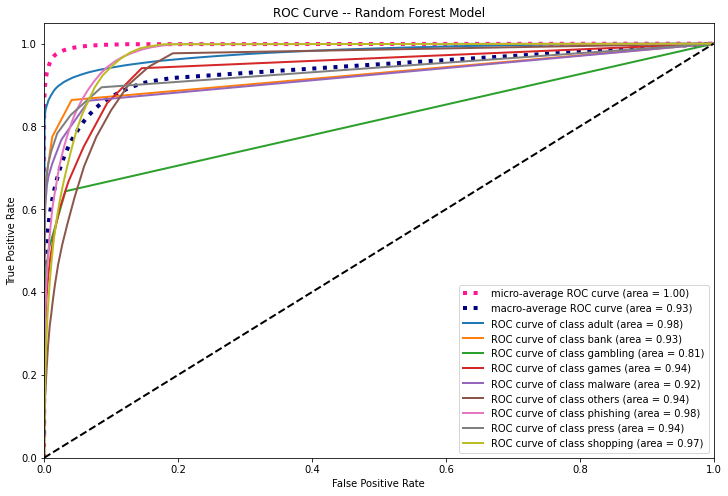

In [18]:
# Compute ROC curve and ROC area for each class
rf_fpr = dict()
rf_tpr = dict()
rf_roc_auc = dict()
for i in range(n_classes):
    rf_fpr[i], rf_tpr[i], _ = roc_curve(y_test[:, i], rf_y_score[:, i])
    rf_roc_auc[i] = auc(rf_fpr[i], rf_tpr[i])
# Compute micro-average ROC curve and ROC area
rf_fpr["micro"], rf_tpr["micro"], _ = roc_curve(y_test.ravel(), rf_y_score.ravel())
rf_roc_auc["micro"] = auc(rf_fpr["micro"], rf_tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
rf_all_fpr = np.unique(np.concatenate([rf_fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
rf_mean_tpr = np.zeros_like(rf_all_fpr)
for i in range(n_classes):
    rf_mean_tpr += interp(rf_all_fpr, rf_fpr[i], rf_tpr[i])

# Finally average it and compute AUC
rf_mean_tpr /= n_classes

rf_fpr["macro"] = rf_all_fpr
rf_tpr["macro"] = rf_mean_tpr
rf_roc_auc["macro"] = auc(rf_fpr["macro"], rf_tpr["macro"])

# Plot all ROC curves
fig = plt.figure(1, figsize=(12, 8))
plt.plot(rf_fpr["micro"], rf_tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(rf_roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(rf_fpr["macro"], rf_tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(rf_roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

cmap = plt.get_cmap("tab10")
colors = cycle([cmap(i) for i in range(n_classes)])

for i, color in zip(range(n_classes), colors):
    plt.plot(rf_fpr[i], rf_tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], rf_roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve -- Random Forest Model')
plt.legend(loc="lower right")
plt.show()

In [19]:
fig.savefig('./roc/roc-toulouse-2017-rf.eps', format='eps', dpi=300);

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [20]:
import pickle

# Load from file
with open('models/toulouse_cat_2017_svm.pickle', 'rb') as file:
    svc_model = pickle.load(file)

In [21]:
%%time
# Actual class predictions
svc_y_pred = svc_model.predict(X_test)
# Probabilities for each class
svc_y_score = svc_model.predict_proba(X_test)

CPU times: user 59min 19s, sys: 2.99 s, total: 59min 22s
Wall time: 59min 23s


/opt/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


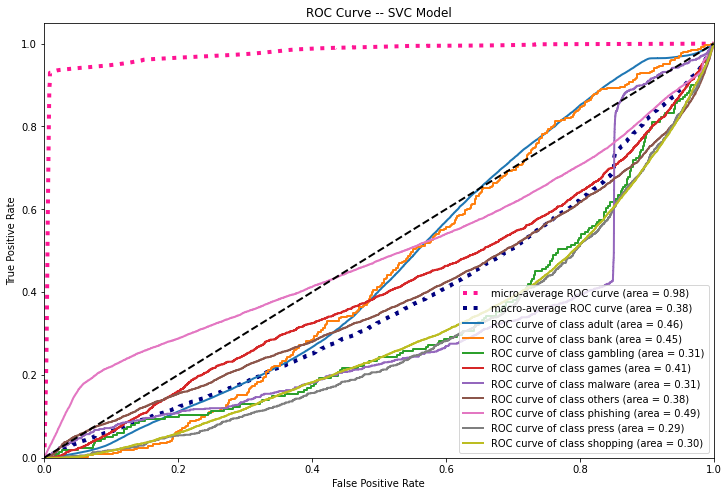

CPU times: user 2.97 s, sys: 888 ms, total: 3.86 s
Wall time: 4.23 s


In [22]:
%%time
# Compute ROC curve and ROC area for each class
svc_fpr = dict()
svc_tpr = dict()
svc_roc_auc = dict()
for i in range(n_classes):
    svc_fpr[i], svc_tpr[i], _ = roc_curve(y_test[:, i], svc_y_score[:, i])
    svc_roc_auc[i] = auc(svc_fpr[i], svc_tpr[i])
# Compute micro-average ROC curve and ROC area
svc_fpr["micro"], svc_tpr["micro"], _ = roc_curve(y_test.ravel(), svc_y_score.ravel())
svc_roc_auc["micro"] = auc(svc_fpr["micro"], svc_tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
svc_all_fpr = np.unique(np.concatenate([svc_fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
svc_mean_tpr = np.zeros_like(svc_all_fpr)
for i in range(n_classes):
    svc_mean_tpr += interp(svc_all_fpr, svc_fpr[i], svc_tpr[i])

# Finally average it and compute AUC
svc_mean_tpr /= n_classes

svc_fpr["macro"] = svc_all_fpr
svc_tpr["macro"] = svc_mean_tpr
svc_roc_auc["macro"] = auc(svc_fpr["macro"], svc_tpr["macro"])

# Plot all ROC curves
fig = plt.figure(1, figsize=(12, 8))
plt.plot(svc_fpr["micro"], svc_tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(svc_roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(svc_fpr["macro"], svc_tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(svc_roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

cmap = plt.get_cmap("tab10")
colors = cycle([cmap(i) for i in range(n_classes)])

for i, color in zip(range(n_classes), colors):
    plt.plot(svc_fpr[i], svc_tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], svc_roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve -- SVC Model')
plt.legend(loc="lower right")
plt.show()


In [23]:
fig.savefig('./roc/roc-toulouse-2017-svc.eps', format='eps', dpi=300);

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


## Save model